# IMPORT

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import Xception

In [2]:
drive.mount('/content/drive')
train_path = '/content/drive/MyDrive/Pós-Graduação/Redes Neurais/Projeto Final/Dataset/Dataset_crop/train'

Mounted at /content/drive


# TREINO

In [3]:
# set batch size
BATCH_SIZE = 64
num_epochs = 90
image_size = 256

In [4]:
# Por exemplo, você pode usar 20% dos dados para validação
# normalization + data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    shear_range=0.4,
    rotation_range = 15,
    vertical_flip=True,
    validation_split=0.15
)

# normalization
val_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# Defina um caminho para seus dados de treinamento
# Divida os dados de treinamento em treinamento e validação
# Por exemplo, você pode usar 20% dos dados para validação
train_data = train_datagen.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,  # Embaralhar os dados de treinamento
    subset='training',  # Especifica o conjunto de treinamento
    seed=42,# Pode especificar uma semente para reprodução
)

val_data = train_datagen.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,  # Não embaralhar os dados de validação
    subset='validation',  # Especifica o conjunto de validação
    seed=42  # Use a mesma semente para garantir a consistência
)

Found 987 images belonging to 2 classes.
Found 173 images belonging to 2 classes.


[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0.]


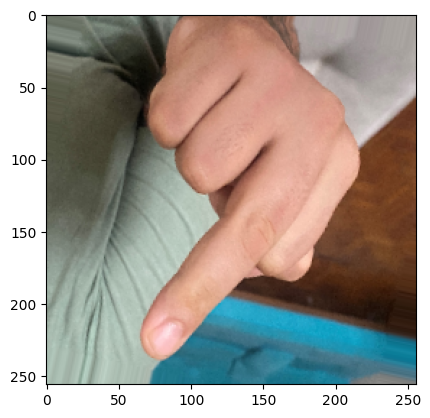

In [6]:
images, _ = next(train_data)
print(_)
plt.imshow(images[3]) # display first image from batch

In [7]:
base_model = Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(image_size, image_size,3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = Input(shape=(image_size, image_size,3))
x = inputs

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)  # Aumentado o dropout
x = tf.keras.layers.Dense(512, activation='relu')(x)  # Mais unidades
x = tf.keras.layers.Dropout(0.3)(x)  # Mais dropout
x = tf.keras.layers.Dense(256, activation='relu')(x)  # Mais unidades
x = tf.keras.layers.Dropout(0.3)(x)  # Mais dropout
x = tf.keras.layers.Dense(128, activation='relu')(x)  # Mais unidades
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='classification')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

83683744/83683744 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0      

In [8]:
lr = 5e-5

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate= lr),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

model.fit(train_data, epochs=num_epochs, validation_data=val_data, batch_size= BATCH_SIZE)

Epoch 1/90
16/16 [==============================] - 299s 18s/step - loss: 0.7247 - binary_accuracy: 0.4934 - val_loss: 0.6703 - val_binary_accuracy: 0.5491
Epoch 2/90
16/16 [==============================] - 53s 3s/step - loss: 0.6666 - binary_accuracy: 0.6008 - val_loss: 0.6673 - val_binary_accuracy: 0.5491
Epoch 3/90
16/16 [==============================] - 51s 3s/step - loss: 0.6611 - binary_accuracy: 0.6089 - val_loss: 0.6554 - val_binary_accuracy: 0.5954
Epoch 4/90
16/16 [==============================] - 53s 3s/step - loss: 0.6342 - binary_accuracy: 0.6545 - val_loss: 0.6433 - val_binary_accuracy: 0.5954
Epoch 5/90
16/16 [==============================] - 56s 4s/step - loss: 0.6089 - binary_accuracy: 0.6687 - val_loss: 0.6435 - val_binary_accuracy: 0.6301
Epoch 6/90
16/16 [==============================] - 56s 4s/step - loss: 0.6027 - binary_accuracy: 0.6879 - val_loss: 0.6211 - val_binary_accuracy: 0.6532
Epoch 7/90
16/16 [==============================] - 56s 4s/step - loss: 0.

In [9]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

history = model.fit(train_data, epochs=num_epochs, validation_data=val_data, batch_size = BATCH_SIZE)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                             

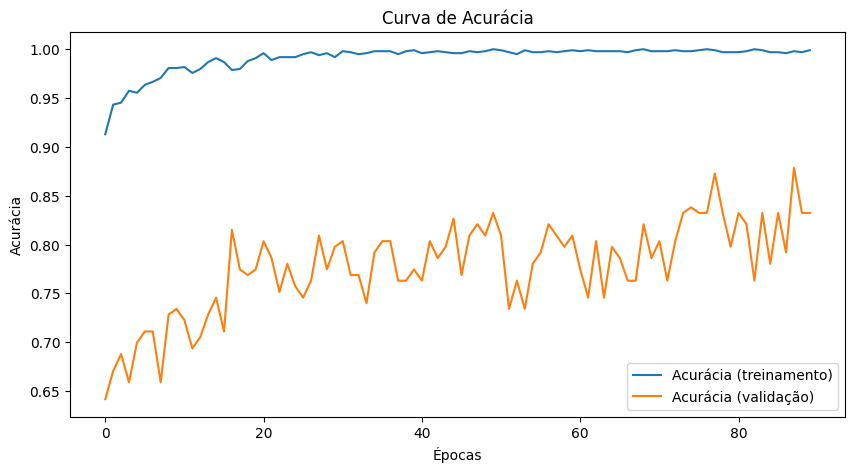

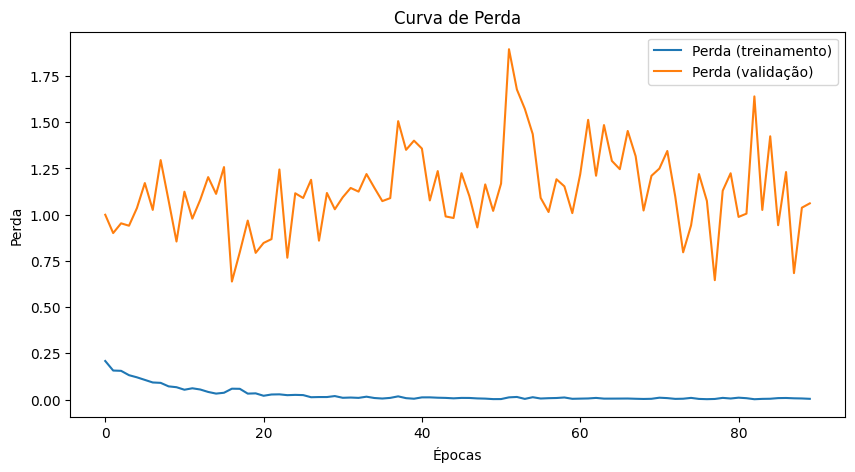

In [10]:
# Plotar a curva de acurácia
plt.figure(figsize=(10, 5))
plt.plot(history.history['binary_accuracy'], label='Acurácia (treinamento)')
plt.plot(history.history['val_binary_accuracy'], label='Acurácia (validação)')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.title('Curva de Acurácia')
plt.show()

# Plotar a curva de perda (loss)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Perda (treinamento)')
plt.plot(history.history['val_loss'], label='Perda (validação)')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.title('Curva de Perda')
plt.show()